In [25]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
import re 
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [3]:
import plotly.express as px
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
plotly.offline.init_notebook_mode(connected=True)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import fasttext
import fasttext.util

fasttext.util.download_model('es', if_exists='ignore')  # Español
model_embeddings = fasttext.load_model('cc.es.300.bin')

In [6]:
def limpiado_de_texto(texto, remove_stop_words=True, stemming_words=True):
    
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # remover numeros
    texto = re.sub(r'\b\d+(?:\.\d+)?\s+', '', texto) 
    # Convertimos textos a minusculas
    texto = texto.lower()
    
    # Tokenizado
    tokenizer = ToktokTokenizer() 
    tokens = tokenizer.tokenize(texto)
    
    # Eliminacion de stopwords
    stop_words =  stopwords.words('spanish')
    if remove_stop_words:
        tokens = [w for w in tokens if not w in stop_words]

    # Stemming
    stemmer = SnowballStemmer("spanish") 
    if stemming_words:
        tokens = [stemmer.stem(token) for token in tokens]
    
    text = " ".join(tokens)
 
    return(text)

In [7]:
data = pd.read_csv('DATA/data.csv')
data

Tipo      Pais   Fuente  \
0     Excelencia Operativa  Colombia     Apps   
1     Excelencia Operativa  Colombia     Apps   
2     Excelencia Operativa  Colombia     Apps   
3     Excelencia Operativa  Colombia     Apps   
4     Excelencia Operativa  Colombia     Apps   
...                    ...       ...      ...   
6902     Futuro sostenible    Mexico  Twitter   
6903     Futuro sostenible    Mexico  Twitter   
6904     Futuro sostenible    Mexico  Twitter   
6905     Futuro sostenible    Mexico  Twitter   
6906     Futuro sostenible    Mexico  Twitter   

                                                  Texto  \
0     Muy mala la app como una hora pidiendo un Códi...   
1                       Un poquito lenta pero excelente   
2     Que aplicacion tan mala, con tanto que roban d...   
3     Muy lenta, se nota lo pesada... Debe ser mas i...   
4               Muy buena lo mejor que han podido crear   
...                                                 ...   
6902  @RicardoAnayaC Habría que comparar con el mund...   
6903  Corte de Caja al Mundo de #Negocios (18/10/21)...   
6904  Los autos eléctricos de Musk volvieron a acele...   
6905  El gigante tecnológico de Taiwán, Foxconn, pre...   
6906  @jrisco @lafuentejavi @el_pais Si, ya ves qué ...   

               FechaPublicacion sentimiento  sentimiento_numerico  
0           2021-10-22 16:22:53    Negativo                  0.00  
1           2021-10-22 16:03:49    Positivo                  0.94  
2           2021-10-22 15:13:42    Negativo                  0.00  
3           2021-10-22 14:56:23    Negativo                  0.00  
4           2021-10-22 14:48:38    Positivo                  0.55  
...                         ...         ...                   ...  
6902  2021-10-18 15:48:12+00:00    Negativo                  0.00  
6903  2021-10-18 15:46:09+00:00    Negativo                  0.45  
6904  2021-10-18 15:46:00+00:00    Negativo                  0.07  
6905  2021-10-18 15:36:28+00:00    Negativo                  0.13  
6906  2021-10-18 15:27:35+00:00    Negativo                  0.00  

[6907 rows x 7 columns]

In [8]:
vector_emmbeding = []

for index, row in tqdm(data.iterrows()):
    
    vector_emmbeding.append(model_embeddings.get_sentence_vector(limpiado_de_texto(row['Texto'],stemming_words= False)).tolist())

6907it [00:01, 4070.93it/s]


In [9]:
vector_scaled = StandardScaler().fit_transform(np.array(vector_emmbeding))

In [10]:
data['embedding'] = vector_scaled.tolist()

In [11]:
comentarios_3d = TSNE(n_components=3).fit_transform(np.array(list(data['embedding'])))

In [12]:
data['x'] = comentarios_3d[:,0]
data['y'] = comentarios_3d[:,1]
data['z'] = comentarios_3d[:,2]

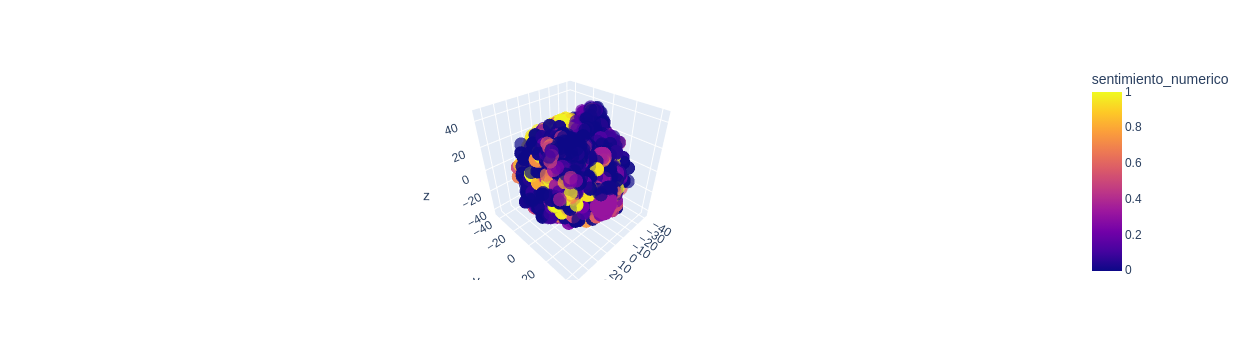

In [14]:
fig = px.scatter_3d(data, x='x', y='y', z='z',color='sentimiento_numerico', opacity=0.7)
fig.show()

# Ayudar a los clientes en la transición hacia un futuro sostenible 
### Tópicos relacionados con temas medio ambientales de twiter 

## Colombia

In [15]:
data_futuro_sostenible_colombia = data.loc[(data['Tipo'] == 'Futuro sostenible') & (data['Pais'] == 'Colombia')]

In [17]:
model_futuro_sostenible_colombia = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
clusters_futuro_sostenible_colombia = model_futuro_sostenible_colombia.fit_predict(np.array(list(data_futuro_sostenible_colombia['embedding'])))
print(metrics.silhouette_score(np.array(list(data_futuro_sostenible_colombia['embedding'])), clusters_futuro_sostenible_colombia))

0.48757012547506934


In [18]:
data_futuro_sostenible_colombia["cluster"] = list(map(chr,clusters_futuro_sostenible_colombia+65))

<ipython-input-18-d5f200a6d025>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
def generete_random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 


def generete_random_symbol():
    list_of_symbols = [ "circle" , "circle-open" , "cross" , "diamond" , "diamond-open" , "square" , "square-open" , "x" ]
    return random.choice(list_of_symbols)
    

def encode_clusters_symbol(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_symbol()})
    
    cluster_encoded = []

    for cluster in list_of_clusters:
        cluster_encoded.append(dict_cluster_value.get(cluster))
        
    return cluster_encoded


def encode_clusters_color(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_color()})
        
    cluster_encoded = []
    
    for cluster in list_of_clusters:
        cluster_encoded.append(dict_cluster_value.get(cluster))
        
    return cluster_encoded


def clusters_color(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_color()})
        
    return dict_cluster_value

In [20]:
def plot_scatter_3d(dataframe, map_html = 'test.html'):
    
    unique_clusters = list(set(list(dataframe['cluster'])))
    unique_clusters.sort()
    
    dict_color = clusters_color(list(dataframe['cluster']))
    
    
    buffer = dataframe.loc[dataframe['cluster'] == unique_clusters[0]]
    
    
    fig = go.Figure(
            data=[
                go.Scatter3d(
                    x=buffer.x, 
                    y=buffer.y, 
                    z=buffer.z,
                    name='Cluster '+ unique_clusters[0],
                    hovertemplate='<b>%{text}</b><extra></extra>',
                    text = [title for title in buffer.Texto],
                    mode='markers',
                    marker=dict(
                        size=8,
                        opacity=0.5,
                        color = dict_color.get(unique_clusters[0]) 
                    )
                )
            ]
        )
    
    
    for i in range(1, len(unique_clusters)):
        
        buffer = dataframe.loc[dataframe['cluster'] == unique_clusters[i]]

        fig.add_trace(
                            go.Scatter3d(
                                x=buffer.x, 
                                y=buffer.y, 
                                z=buffer.z,
                                name='Cluster '+ unique_clusters[i],
                                hovertemplate='<b>%{text}</b><extra></extra>',
                                text = [title for title in buffer.Texto],
                                mode='markers',
                                marker=dict(
                                    size=8,
                                    opacity=0.5,
                                    color = dict_color.get(unique_clusters[i]) 
                                )
                            )
                        
                    
                )
        
        
    
    fig.update_traces(showlegend=True)
    fig.show()
    fig.write_html(map_html)
    

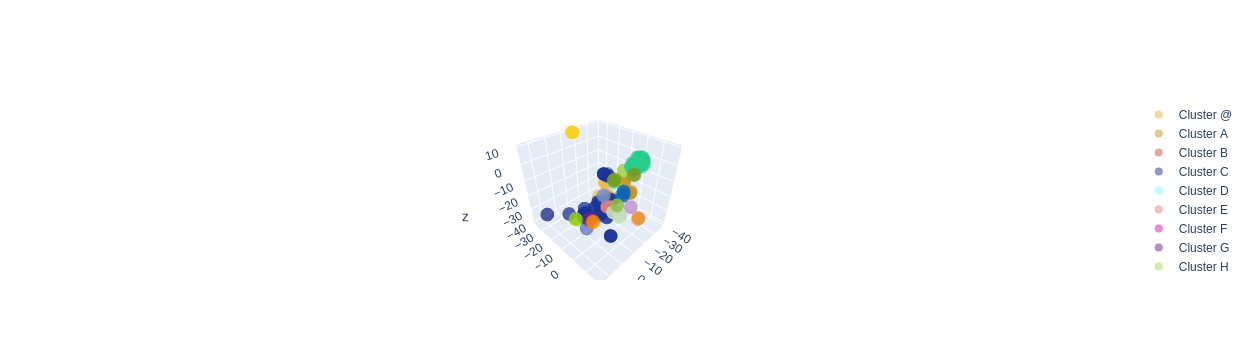

In [21]:
plot_scatter_3d(data_futuro_sostenible_colombia, 'GRAFICAS/SCATTERS/futuro_sostenible_colombia.html')

In [187]:
def generate_wordcloud_from_cluster(dataframe, folder, show_image = True):
    
    unique_clusters = list(set(list(dataframe['cluster'])))
    unique_clusters.sort()
    
    for i in range(len(unique_clusters)):
        
        buffer = dataframe.loc[dataframe['cluster'] == unique_clusters[i]]
        
        text = ' '.join(list(buffer['Texto']))
        
        stop_words =  stopwords.words('spanish')
        stop_words.append('https')
        stop_words.append('t')
        stop_words.append('co')
        
        try:
        
            wordcloud = WordCloud(width = 1600, height = 800,stopwords = stop_words, background_color="white").generate(text)
        
        except:
            
            wordcloud = WordCloud(width = 1600, height = 800,stopwords = stop_words, background_color="white").generate('empty')

        # Display the generated image:
        
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(folder + '/' + unique_clusters[i] + '.png')
        
        if show_image:
            print('Cluster ' + unique_clusters[i])
            plt.show()


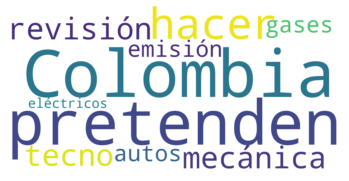

In [80]:
generate_wordcloud_from_cluster(data_futuro_sostenible_colombia, 'GRAFICAS/Word_clouds/futuro_sostenible/colombia', show_image=False)

## Espana

In [60]:
data_futuro_sostenible_espana = data.loc[(data['Tipo'] == 'Futuro sostenible') & (data['Pais'] == 'España')]

In [66]:
model_futuro_sostenible_espana = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_futuro_sostenible_espana = model_futuro_sostenible_espana.fit_predict(np.array(list(data_futuro_sostenible_espana['embedding'])))
print(metrics.silhouette_score(np.array(list(data_futuro_sostenible_espana['embedding'])), clusters_futuro_sostenible_espana))

0.202956361780708


In [74]:
data_futuro_sostenible_espana["cluster"] = list(map(chr,clusters_futuro_sostenible_espana+65))

<ipython-input-74-614238a4c661>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



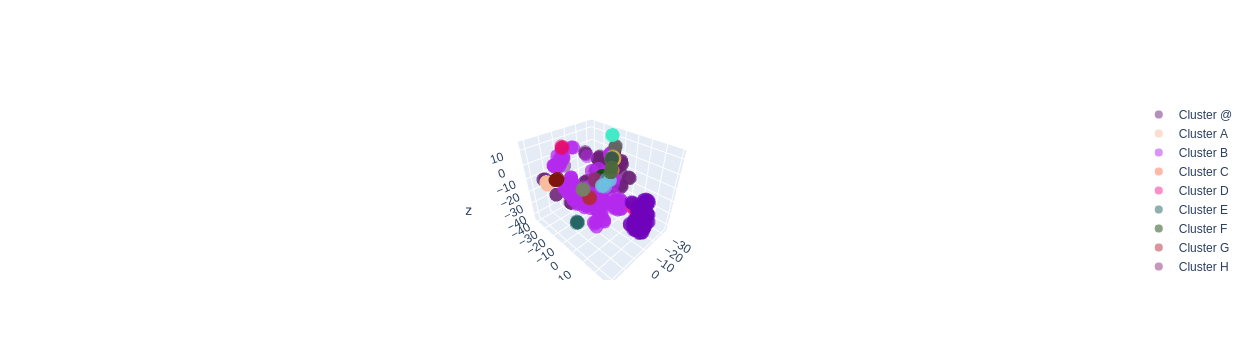

In [91]:
plot_scatter_3d(data_futuro_sostenible_espana, 'GRAFICAS/SCATTERS/futuro_sostenible_espana.html')

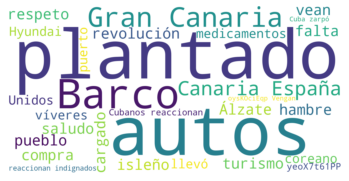

In [82]:
generate_wordcloud_from_cluster(data_futuro_sostenible_espana, 'GRAFICAS/Word_clouds/futuro_sostenible/espana', show_image=False)

# Mexico

In [83]:
data_futuro_sostenible_mexico = data.loc[(data['Tipo'] == 'Futuro sostenible') & (data['Pais'] == 'Mexico')]

In [85]:
model_futuro_sostenible_mexico = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_futuro_sostenible_mexico = model_futuro_sostenible_mexico.fit_predict(np.array(list(data_futuro_sostenible_mexico['embedding'])))
print(metrics.silhouette_score(np.array(list(data_futuro_sostenible_mexico['embedding'])), clusters_futuro_sostenible_mexico))

-0.039074106800939576


In [86]:
data_futuro_sostenible_mexico["cluster"] = list(map(chr,clusters_futuro_sostenible_mexico+65))

<ipython-input-86-a4b7ff814c0b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



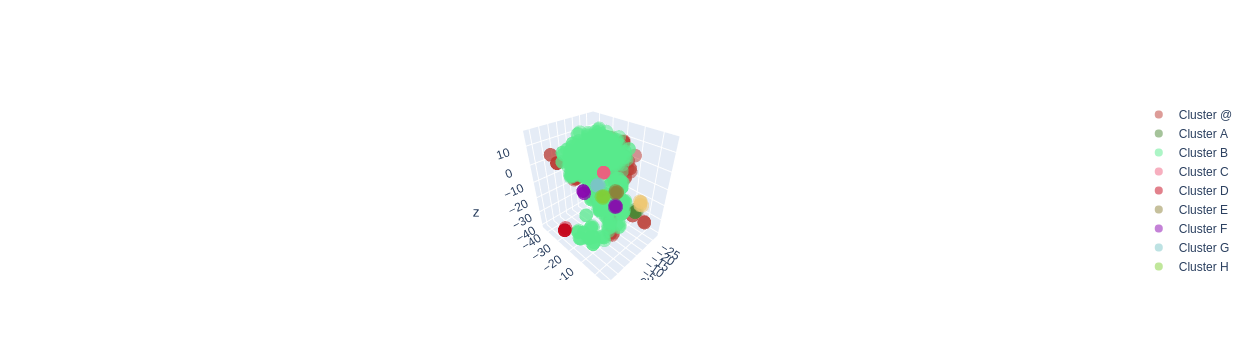

In [94]:
plot_scatter_3d(data_futuro_sostenible_mexico, 'GRAFICAS/SCATTERS/futuro_sostenible_mexico.html')

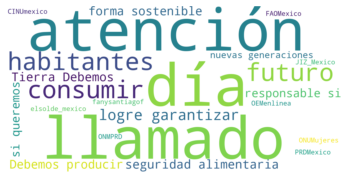

In [96]:
generate_wordcloud_from_cluster(data_futuro_sostenible_mexico, 'GRAFICAS/Word_clouds/futuro_sostenible/mexico', show_image=False)

# Crecer en clientes 
### Analizar los tweets relacionados con la competencia 

## Colombia

### Comentarios positivos

In [100]:
data_crecerclientes_colombia_positivos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'Colombia') & (data['sentimiento'] == 'Positivo')]

In [107]:
model_crecerclientes_colombia_positivos = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_crecerclientes_colombia_positivos = model_crecerclientes_colombia_positivos.fit_predict(np.array(list(data_crecerclientes_colombia_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_colombia_positivos['embedding'])), clusters_crecerclientes_colombia_positivos))

0.040625221278575915


In [108]:
data_crecerclientes_colombia_positivos["cluster"] = list(map(chr,clusters_crecerclientes_colombia_positivos+65))

<ipython-input-108-84424e27a6ba>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
plot_scatter_3d(data_crecerclientes_colombia_positivos, 'GRAFICAS/SCATTERS/crecer en clientes/colombia/crecerclientes_colombia_positivos.html')

Cluster @


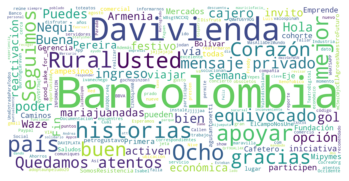

Cluster A


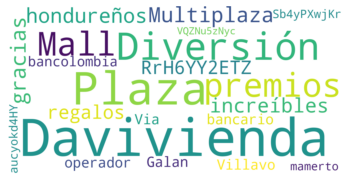

Cluster B


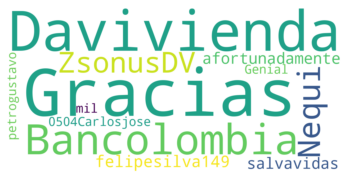

In [110]:
generate_wordcloud_from_cluster(data_crecerclientes_colombia_positivos, 'GRAFICAS/Word_clouds/crecer_clientes/colombia/positivo', show_image=True)

### Comentarios negativos

In [111]:
data_crecerclientes_colombia_negativos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'Colombia') & (data['sentimiento'] == 'Negativo')]

In [150]:
model_crecerclientes_colombia_negativos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_crecerclientes_colombia_negativos = model_crecerclientes_colombia_negativos.fit_predict(np.array(list(data_crecerclientes_colombia_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_colombia_negativos['embedding'])), clusters_crecerclientes_colombia_negativos))

-0.10631205630176663


In [151]:
data_crecerclientes_colombia_negativos["cluster"] = list(map(chr,clusters_crecerclientes_colombia_negativos+65))

<ipython-input-151-41424384637d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [152]:
plot_scatter_3d(data_crecerclientes_colombia_negativos, 'GRAFICAS/SCATTERS/crecer en clientes/colombia/crecerclientes_colombia_negativo.html')

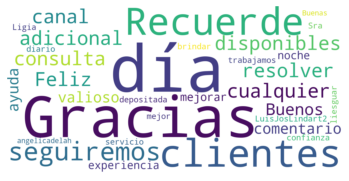

In [153]:
generate_wordcloud_from_cluster(data_crecerclientes_colombia_negativos, 'GRAFICAS/Word_clouds/crecer_clientes/colombia/negativo', show_image=False)

# Espana

### Comentarios positivos

In [154]:
data_crecerclientes_espana_positivos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'España') & (data['sentimiento'] == 'Positivo')]

In [155]:
model_crecerclientes_espana_positivos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_crecerclientes_espana_positivos = model_crecerclientes_espana_positivos.fit_predict(np.array(list(data_crecerclientes_espana_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_espana_positivos['embedding'])), clusters_crecerclientes_espana_positivos))
data_crecerclientes_espana_positivos["cluster"] = list(map(chr,clusters_crecerclientes_espana_positivos+65))

0.5081568112908862


<ipython-input-155-47430066bda2>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [157]:
plot_scatter_3d(data_crecerclientes_espana_positivos, 'GRAFICAS/SCATTERS/crecer en clientes/espana/crecerclientes_espana_positivos.html')

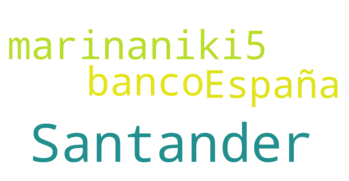

In [158]:
generate_wordcloud_from_cluster(data_crecerclientes_espana_positivos, 'GRAFICAS/Word_clouds/crecer_clientes/espana/positivo', show_image=False)

### Comentarios negativos

In [159]:
data_crecerclientes_espana_negativos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'España') & (data['sentimiento'] == 'Negativo')]

In [160]:
model_crecerclientes_espana_negativos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_crecerclientes_espana_negativos = model_crecerclientes_espana_negativos.fit_predict(np.array(list(data_crecerclientes_espana_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_espana_negativos['embedding'])), clusters_crecerclientes_espana_negativos))
data_crecerclientes_espana_negativos["cluster"] = list(map(chr,clusters_crecerclientes_espana_negativos+65))

0.7784094221741292


<ipython-input-160-f677b98ecd79>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [161]:
plot_scatter_3d(data_crecerclientes_espana_negativos, 'GRAFICAS/SCATTERS/crecer en clientes/espana/crecerclientes_espana_negativos.html')

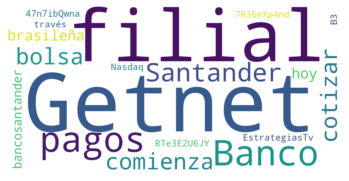

In [162]:
generate_wordcloud_from_cluster(data_crecerclientes_espana_negativos, 'GRAFICAS/Word_clouds/crecer_clientes/espana/negativo', show_image=False)

# Mexico

### Comentarios positivos

In [163]:
data_crecerclientes_mexico_positivos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'Mexico') & (data['sentimiento'] == 'Positivo')]

In [169]:
model_crecerclientes_mexico_positivos = DBSCAN(eps=0.4, min_samples=3, metric='cosine')
clusters_crecerclientes_mexico_positivos = model_crecerclientes_mexico_positivos.fit_predict(np.array(list(data_crecerclientes_mexico_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_mexico_positivos['embedding'])), clusters_crecerclientes_mexico_positivos))
data_crecerclientes_mexico_positivos["cluster"] = list(map(chr,clusters_crecerclientes_mexico_positivos+65))

0.06570648506079518


<ipython-input-169-9ba2565a7b09>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [170]:
plot_scatter_3d(data_crecerclientes_mexico_positivos, 'GRAFICAS/SCATTERS/crecer en clientes/mexico/crecerclientes_mexico_positivos.html')

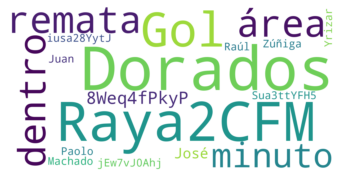

In [171]:
generate_wordcloud_from_cluster(data_crecerclientes_mexico_positivos, 'GRAFICAS/Word_clouds/crecer_clientes/mexico/positivo', show_image=False)

### Comentarios negativos

In [173]:
data_crecerclientes_mexico_negativos = data.loc[(data['Tipo'] == 'Crecer Clientes') & (data['Pais'] == 'Mexico') & (data['sentimiento'] == 'Negativo')]

In [174]:
model_crecerclientes_mexico_negativos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_crecerclientes_mexico_negativos = model_crecerclientes_mexico_negativos.fit_predict(np.array(list(data_crecerclientes_mexico_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_crecerclientes_mexico_negativos['embedding'])), clusters_crecerclientes_mexico_negativos))
data_crecerclientes_mexico_negativos["cluster"] = list(map(chr,clusters_crecerclientes_mexico_negativos+65))

-0.0532202202061388


<ipython-input-174-e8ede7ca8878>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [175]:
plot_scatter_3d(data_crecerclientes_mexico_negativos, 'GRAFICAS/SCATTERS/crecer en clientes/mexico/crecerclientes_mexico_negativos.html')

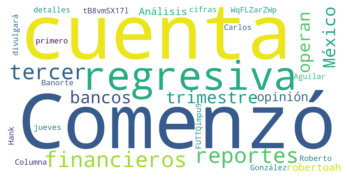

In [176]:
generate_wordcloud_from_cluster(data_crecerclientes_mexico_negativos, 'GRAFICAS/Word_clouds/crecer_clientes/mexico/negativo', show_image=False)

# Buscar la excelencia operativa 
### Analizar los tweets relacionados a bbva y los comentarios de las aplicaciones, y ver qué problemáticas dan a conocer sus clientes

# Colombia

### Comentarios positivos

In [177]:
data_exceloperativa_colombia_positivos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'Colombia') & (data['sentimiento'] == 'Positivo')]

In [178]:
model_exceloperativa_colombia_positivos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_exceloperativa_colombia_positivos = model_exceloperativa_colombia_positivos.fit_predict(np.array(list(data_exceloperativa_colombia_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_colombia_positivos['embedding'])), clusters_exceloperativa_colombia_positivos))
data_exceloperativa_colombia_positivos["cluster"] = list(map(chr,clusters_exceloperativa_colombia_positivos+65))

0.2506434548237386


<ipython-input-178-7a4a1bbecc9d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [179]:
plot_scatter_3d(data_exceloperativa_colombia_positivos, 'GRAFICAS/SCATTERS/excelencia operativa/colombia/exceloperativa_colombia_positivos.html')

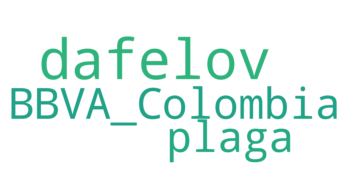

In [180]:
generate_wordcloud_from_cluster(data_exceloperativa_colombia_positivos, 'GRAFICAS/Word_clouds/excel_operativa/colombia/positivo', show_image=False)

### Comentarios negativos

In [181]:
data_exceloperativa_colombia_negativos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'Colombia') & (data['sentimiento'] == 'Negativo')]

In [184]:
model_exceloperativa_colombia_negativos = DBSCAN(eps=0.3, min_samples=3, metric='cosine')
clusters_exceloperativa_colombia_negativos = model_exceloperativa_colombia_negativos.fit_predict(np.array(list(data_exceloperativa_colombia_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_colombia_negativos['embedding'])), clusters_exceloperativa_colombia_negativos))
data_exceloperativa_colombia_negativos["cluster"] = list(map(chr,clusters_exceloperativa_colombia_negativos+65))

0.29162775482179915


<ipython-input-184-e2748b04d419>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [185]:
plot_scatter_3d(data_exceloperativa_colombia_negativos, 'GRAFICAS/SCATTERS/excelencia operativa/colombia/exceloperativa_colombia_negativos.html')

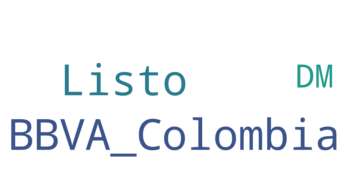

In [188]:
generate_wordcloud_from_cluster(data_exceloperativa_colombia_negativos, 'GRAFICAS/Word_clouds/excel_operativa/colombia/negativo', show_image=False)

## Espana

### Comentarios positivos

In [189]:
data_exceloperativa_espana_positivos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'España') & (data['sentimiento'] == 'Positivo')]

In [190]:
model_exceloperativa_espana_positivos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_exceloperativa_espana_positivos = model_exceloperativa_espana_positivos.fit_predict(np.array(list(data_exceloperativa_espana_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_espana_positivos['embedding'])), clusters_exceloperativa_espana_positivos))
data_exceloperativa_espana_positivos["cluster"] = list(map(chr,clusters_exceloperativa_espana_positivos+65))

0.26138419318045975


<ipython-input-190-4e8042efb270>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [192]:
plot_scatter_3d(data_exceloperativa_espana_positivos, 'GRAFICAS/SCATTERS/excelencia operativa/espana/exceloperativa_espana_positivos.html')

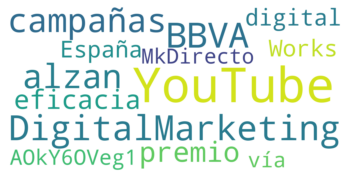

In [193]:
generate_wordcloud_from_cluster(data_exceloperativa_espana_positivos, 'GRAFICAS/Word_clouds/excel_operativa/espana/positivo', show_image=False)

### Comentarios negativos

In [194]:
data_exceloperativa_espana_negativos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'España') & (data['sentimiento'] == 'Negativo')]

In [195]:
model_exceloperativa_espana_negativos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_exceloperativa_espana_negativos = model_exceloperativa_espana_negativos.fit_predict(np.array(list(data_exceloperativa_espana_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_espana_negativos['embedding'])), clusters_exceloperativa_espana_negativos))
data_exceloperativa_espana_negativos["cluster"] = list(map(chr,clusters_exceloperativa_espana_negativos+65))

0.3940546092724551


<ipython-input-195-e0d9c0cac3dc>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [196]:
plot_scatter_3d(data_exceloperativa_espana_negativos, 'GRAFICAS/SCATTERS/excelencia operativa/espana/exceloperativa_espana_negativos.html')

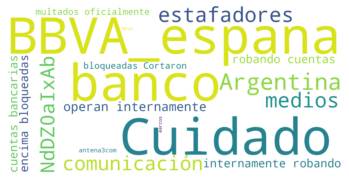

In [197]:
generate_wordcloud_from_cluster(data_exceloperativa_espana_negativos, 'GRAFICAS/Word_clouds/excel_operativa/espana/negativo', show_image=False)

## Mexico

### Comentarios positivos

In [198]:
data_exceloperativa_mexico_positivos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'Mexico') & (data['sentimiento'] == 'Positivo')]

In [199]:
model_exceloperativa_mexico_positivos = DBSCAN(eps=0.25, min_samples=3, metric='cosine')
clusters_exceloperativa_mexico_positivos = model_exceloperativa_mexico_positivos.fit_predict(np.array(list(data_exceloperativa_mexico_positivos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_mexico_positivos['embedding'])), clusters_exceloperativa_mexico_positivos))
data_exceloperativa_mexico_positivos["cluster"] = list(map(chr,clusters_exceloperativa_mexico_positivos+65))

0.2179573812149381


<ipython-input-199-ce121058b72e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
plot_scatter_3d(data_exceloperativa_mexico_positivos, 'GRAFICAS/SCATTERS/excelencia operativa/mexico/exceloperativa_mexico_positivos.html')

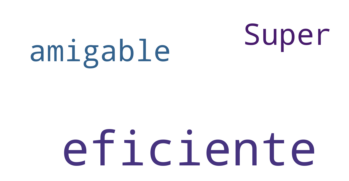

In [201]:
generate_wordcloud_from_cluster(data_exceloperativa_mexico_positivos, 'GRAFICAS/Word_clouds/excel_operativa/espana/positivo', show_image=False)

### Comentarios negativos

In [202]:
data_exceloperativa_mexico_negativos = data.loc[(data['Tipo'] == 'Excelencia Operativa') & (data['Pais'] == 'Mexico') & (data['sentimiento'] == 'Negativo')]

In [219]:
model_exceloperativa_mexico_negativos = DBSCAN(eps=0.25, min_samples=2, metric='cosine')
clusters_exceloperativa_mexico_negativos = model_exceloperativa_mexico_negativos.fit_predict(np.array(list(data_exceloperativa_mexico_negativos['embedding'])))
print(metrics.silhouette_score(np.array(list(data_exceloperativa_mexico_negativos['embedding'])), clusters_exceloperativa_mexico_negativos))
data_exceloperativa_mexico_negativos["cluster"] = list(map(chr,clusters_exceloperativa_mexico_negativos+65))

-0.11563330936094819


<ipython-input-219-801327ddc8f3>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
plot_scatter_3d(data_exceloperativa_mexico_negativos, 'GRAFICAS/SCATTERS/excelencia operativa/mexico/exceloperativa_mexico_negativos.html')

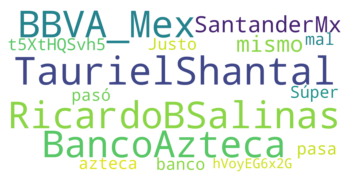

In [221]:
generate_wordcloud_from_cluster(data_exceloperativa_mexico_negativos, 'GRAFICAS/Word_clouds/excel_operativa/mexico/negativo', show_image=False)